(1) Use the precipitation output of ERA-5 to compute a time series of daily precipitation at a given point closest to a city of your choosing. Choose a box of 5 x 5 deg lat-lon values over the grid box closest to the city you are examining.  Save this data.  Use a period of at least 10 years.

In [1]:
# I think importing these packages is redundant when we're using the xarray-climate environment,
# but it can't hurt...right?

import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dask

plt.rcParams['figure.figsize'] = (10,5)
plt.rcParams['figure.dpi'] = 120

print('xarray', xr.__version__)

xarray 2025.9.0


In [2]:
from dask.distributed import Client
client = Client()  # set up local cluster on your machine
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38059,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:42983,Total threads: 1
Dashboard: http://127.0.0.1:35785/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:33383,


In [3]:
import gcsfs
fs = gcsfs.GCSFileSystem(token="anon")
# Should list arrays/metadata keys under the store
print(fs.ls("gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3")[:10])

['gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/.zattrs', 'gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/.zgroup', 'gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/.zmetadata', 'gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/100m_u_component_of_wind', 'gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/100m_v_component_of_wind', 'gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/10m_u_component_of_neutral_wind', 'gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/10m_u_component_of_wind', 'gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/10m_v_component_of_neutral_wind', 'gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/10m_v_component_of_wind', 'gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/10m_wind_gust_since_previous_post_processing']


In [4]:
ds = xr.open_zarr(
    'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3',
    chunks=None,
    storage_options=dict(token='anon'),
)
ds = ds.sel(time=slice(ds.attrs['valid_time_start'], ds.attrs['valid_time_stop']))
ds

<xarray.Dataset> Size: 2PB
Dimensions:                                                          (
                                                                      time: 748008,
                                                                      latitude: 721,
                                                                      longitude: 1440,
                                                                      level: 37)
Coordinates:
  * latitude                                                         (latitude) float32 3kB ...
  * level                                                            (level) int64 296B ...
  * longitude                                                        (longitude) float32 6kB ...
  * time                                                             (time) datetime64[ns] 6MB ...
Data variables: (12/273)
    100m_u_component_of_wind                                         (time, latitude, longitude) float32 3TB ...
    100m_v_component_of_wind                                         (time, latitude, longitude) float32 3TB ...
    10m_u_component_of_neutral_wind                                  (time, latitude, longitude) float32 3TB ...
    10m_u_component_of_wind                                          (time, latitude, longitude) float32 3TB ...
    10m_v_component_of_neutral_wind                                  (time, latitude, longitude) float32 3TB ...
    10m_v_component_of_wind                                          (time, latitude, longitude) float32 3TB ...
    ...                                                               ...
    wave_spectral_directional_width_for_swell                        (time, latitude, longitude) float32 3TB ...
    wave_spectral_directional_width_for_wind_waves                   (time, latitude, longitude) float32 3TB ...
    wave_spectral_kurtosis                                           (time, latitude, longitude) float32 3TB ...
    wave_spectral_peakedness                                         (time, latitude, longitude) float32 3TB ...
    wave_spectral_skewness                                           (time, latitude, longitude) float32 3TB ...
    zero_degree_level                                                (time, latitude, longitude) float32 3TB ...
Attributes:
    last_updated:           2025-09-24 01:56:16.783170+00:00
    valid_time_start:       1940-01-01
    valid_time_stop:        2025-04-30
    valid_time_stop_era5t:  2025-09-18

First I want to review the available variables so I can select the one for precipitation.

In [5]:
list(ds.data_vars)

['100m_u_component_of_wind',
 '100m_v_component_of_wind',
 '10m_u_component_of_neutral_wind',
 '10m_u_component_of_wind',
 '10m_v_component_of_neutral_wind',
 '10m_v_component_of_wind',
 '10m_wind_gust_since_previous_post_processing',
 '2m_dewpoint_temperature',
 '2m_temperature',
 'air_density_over_the_oceans',
 'angle_of_sub_gridscale_orography',
 'anisotropy_of_sub_gridscale_orography',
 'benjamin_feir_index',
 'boundary_layer_dissipation',
 'boundary_layer_height',
 'charnock',
 'clear_sky_direct_solar_radiation_at_surface',
 'cloud_base_height',
 'coefficient_of_drag_with_waves',
 'convective_available_potential_energy',
 'convective_inhibition',
 'convective_precipitation',
 'convective_rain_rate',
 'convective_snowfall',
 'convective_snowfall_rate_water_equivalent',
 'downward_uv_radiation_at_the_surface',
 'duct_base_height',
 'eastward_gravity_wave_surface_stress',
 'eastward_turbulent_surface_stress',
 'evaporation',
 'forecast_albedo',
 'forecast_logarithm_of_surface_roughne

Here I am creating a subset dataset and (1) establishing my time range (2012-2022) and also (2) pulling out my variable of interest (precipitation).

In [6]:
var = 'total_precipitation'
ds1 = ds[var].sel(time=slice('2012-01-01 00:00','2022-12-31 23:59'))
ds1

<xarray.DataArray 'total_precipitation' (time: 96432, latitude: 721,
                                         longitude: 1440)> Size: 400GB
[100119559680 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time       (time) datetime64[ns] 771kB 2012-01-01 ... 2022-12-31T23:00:00
Attributes:
    long_name:   Total precipitation
    short_name:  tp
    units:       m

Now subset by region. The city I am focusing on is Santa Barbara, CA.

In [7]:
ds2 = ds1.sel(latitude=slice(37,32),longitude=slice(-122+360,-117+360))
ds2

<xarray.DataArray 'total_precipitation' (time: 96432, latitude: 21,
                                         longitude: 21)> Size: 170MB
[42526512 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float32 84B 37.0 36.75 36.5 36.25 ... 32.5 32.25 32.0
  * longitude  (longitude) float32 84B 238.0 238.2 238.5 ... 242.5 242.8 243.0
  * time       (time) datetime64[ns] 771kB 2012-01-01 ... 2022-12-31T23:00:00
Attributes:
    long_name:   Total precipitation
    short_name:  tp
    units:       m

In [8]:
print(ds2.dims)
print(type(ds2))

('time', 'latitude', 'longitude')
<class 'xarray.core.dataarray.DataArray'>


In [10]:
ds3 = ds2.resample(time='1D').mean()

In [45]:
ds3.to_netcdf("daily_precip_sb.nc")

In [ ]:
ds3 = xr.open_dataarray("daily_precip_sb.nc") 

In [10]:
print(type(ds3))
ds3

<class 'xarray.core.dataarray.DataArray'>


<xarray.DataArray 'total_precipitation' (time: 4018, latitude: 21, longitude: 21)> Size: 7MB
[1771938 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float32 84B 37.0 36.75 36.5 36.25 ... 32.5 32.25 32.0
  * longitude  (longitude) float32 84B 238.0 238.2 238.5 ... 242.5 242.8 243.0
  * time       (time) datetime64[ns] 32kB 2012-01-01 2012-01-02 ... 2022-12-31
Attributes:
    long_name:   Total precipitation
    short_name:  tp
    units:       m

In [11]:
ds_spatial_mean = ds3.mean(dim=['latitude','longitude'])

In [26]:
# convert from m to mm.

ds_mm = ds_spatial_mean*1000

In [27]:
print(type(ds_mm))
print(ds_mm.dims)

<class 'xarray.core.dataarray.DataArray'>
('time',)


The plot below is a time series of daily precipitation data from ERA 5 within a 5x5 lat/lon box that encompasses the City of Santa Barbara over a 10-year range from 2012-2022.

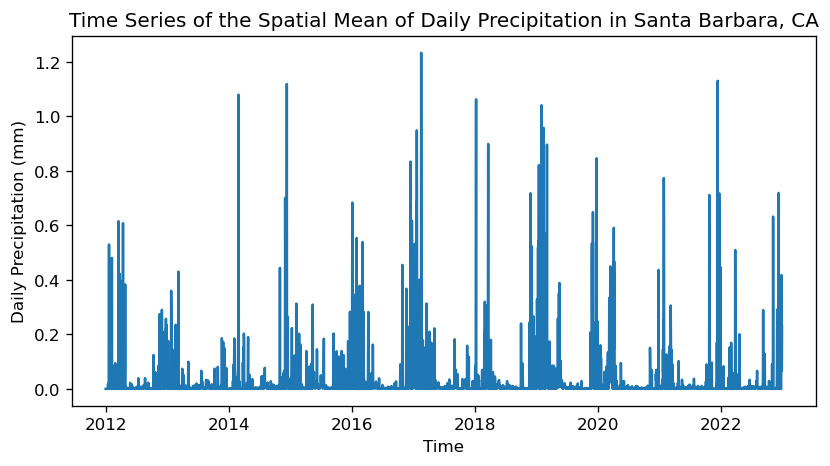

In [28]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(ds_mm['time'], ds_mm.values)
ax.set_title("Time Series of the Spatial Mean of Daily Precipitation in Santa Barbara, CA")
ax.set_xlabel("Time")
ax.set_ylabel("Daily Precipitation (mm)")
plt.show()

(2) Determine the 95% values of daily precipitation for the data created in (1).  Plot a *cumulative distribution function* of all values daily precipitation values and illustrate the 95% value of daily precipitation in millimeters.

In [29]:
p95 = ds_mm.quantile(0.95)
p95

<xarray.DataArray 'total_precipitation' ()> Size: 8B
array(0.15690992)
Coordinates:
    quantile  float64 8B 0.95

p95 is technically a data array but it holds only one value, and that is the value of the 95th percentile daily precipitation of my chosen subset of data: 0.15691 millimeters per day.

In [30]:
# Convert to a 1D NumPy array
vals = ds_mm.values

# Sort the data (needed for a CDF)
sorted_vals = np.sort(vals)

# Compute cumulative probabilities
cdf = np.arange(1, len(sorted_vals) + 1) / len(sorted_vals)

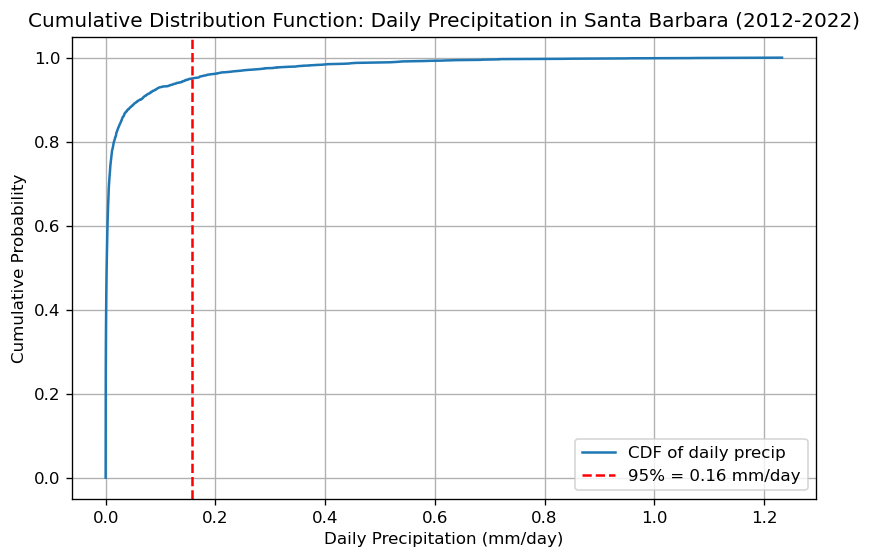

In [32]:
plt.figure(figsize=(8,5))
plt.plot(sorted_vals, cdf, label="CDF of daily precip")

# Add a vertical line for the 95th percentile
plt.axvline(p95, color="red", ls="--", label=f"95% = {p95:.2f} mm/day")

plt.xlabel("Daily Precipitation (mm/day)")
plt.ylabel("Cumulative Probability")
plt.title("Cumulative Distribution Function: Daily Precipitation in Santa Barbara (2012-2022)")
plt.legend()
plt.grid(True)
plt.show()

(3) Create a map of the composite mean precipitation on the 95% days identified in (2) over the continental USA, and a map of the anomaly of precipitation from the 1981-2010 mean. This field should be plotted on a Cartopy map centered at your city with a 40 x 40 degree lat-lon range.

In [33]:
# Boolean mask of days with daily precipitation ≥ 95th percentile
mask_sb_95 = ds_mm >= p95

In [34]:
ds_us = ds[var].sel(time=slice('2012-01-01 00:00','2022-12-31 23:59'),latitude=slice(50,24),longitude=slice(-125+360,-66+360))
ds_us

<xarray.DataArray 'total_precipitation' (time: 96432, latitude: 105,
                                         longitude: 237)> Size: 10GB
[2399710320 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float32 420B 50.0 49.75 49.5 49.25 ... 24.5 24.25 24.0
  * longitude  (longitude) float32 948B 235.0 235.2 235.5 ... 293.5 293.8 294.0
  * time       (time) datetime64[ns] 771kB 2012-01-01 ... 2022-12-31T23:00:00
Attributes:
    long_name:   Total precipitation
    short_name:  tp
    units:       m

In [35]:
ds_us_19812010 = ds[var].sel(time=slice('1981-01-01 00:00','2010-12-31 23:59'),latitude=slice(50,24),longitude=slice(-125+360,-66+360))
ds_us

<xarray.DataArray 'total_precipitation' (time: 96432, latitude: 105,
                                         longitude: 237)> Size: 10GB
[2399710320 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float32 420B 50.0 49.75 49.5 49.25 ... 24.5 24.25 24.0
  * longitude  (longitude) float32 948B 235.0 235.2 235.5 ... 293.5 293.8 294.0
  * time       (time) datetime64[ns] 771kB 2012-01-01 ... 2022-12-31T23:00:00
Attributes:
    long_name:   Total precipitation
    short_name:  tp
    units:       m

In [17]:
ds_us_19812010_daily = ds_us_19812010.resample(time='1D').mean()

In [18]:
ds_us_19812010_daily.to_netcdf('daily_precip_conus_19812010.nc')

In [36]:
ds_us_19812010_daily = xr.open_dataarray("daily_precip_conus_19812010.nc") 

In [37]:
ds_us_19812010_mean = ds_us_19812010_daily.mean(dim='time')

In [38]:
ds_us_19812010_mean_mm = ds_us_19812010_mean*1000

In [43]:
ds_us_daily = ds_us.resample(time='1D').mean()

In [46]:
ds_us_daily.to_netcdf('daily_precip_conus.nc')

In [39]:
ds_us_daily = xr.open_dataset("daily_precip_conus.nc") 
ds_us_daily

<xarray.Dataset> Size: 400MB
Dimensions:              (time: 4018, latitude: 105, longitude: 237)
Coordinates:
  * latitude             (latitude) float32 420B 50.0 49.75 49.5 ... 24.25 24.0
  * longitude            (longitude) float32 948B 235.0 235.2 ... 293.8 294.0
  * time                 (time) datetime64[ns] 32kB 2012-01-01 ... 2022-12-31
Data variables:
    total_precipitation  (time, latitude, longitude) float32 400MB ...

In [48]:
ds_us_daily_mm = ds_us_daily*1000

In [49]:
ds_95days = ds_us_daily_mm.sel(time=mask_sb_95)

In [50]:
ds_95days

<xarray.Dataset> Size: 20MB
Dimensions:              (latitude: 105, longitude: 237, time: 201)
Coordinates:
  * latitude             (latitude) float32 420B 50.0 49.75 49.5 ... 24.25 24.0
  * longitude            (longitude) float32 948B 235.0 235.2 ... 293.8 294.0
  * time                 (time) datetime64[ns] 2kB 2012-01-21 ... 2022-12-31
    quantile             float64 8B 0.95
Data variables:
    total_precipitation  (time, latitude, longitude) float32 20MB 1.165 ... 0...

In [51]:
# need to collapse the dataset into 2D to plot, so taking the composite
# mean over these days
mean_95days = ds_95days.mean(dim='time')
print(mean_95days)

<xarray.Dataset> Size: 101kB
Dimensions:              (latitude: 105, longitude: 237)
Coordinates:
  * latitude             (latitude) float32 420B 50.0 49.75 49.5 ... 24.25 24.0
  * longitude            (longitude) float32 948B 235.0 235.2 ... 293.8 294.0
    quantile             float64 8B 0.95
Data variables:
    total_precipitation  (latitude, longitude) float32 100kB 0.1795 ... 0.1202


In [43]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

Part one of question 3: Below is a map of the composite mean precipitation on the 95% days identified in (2) over the continental USA 

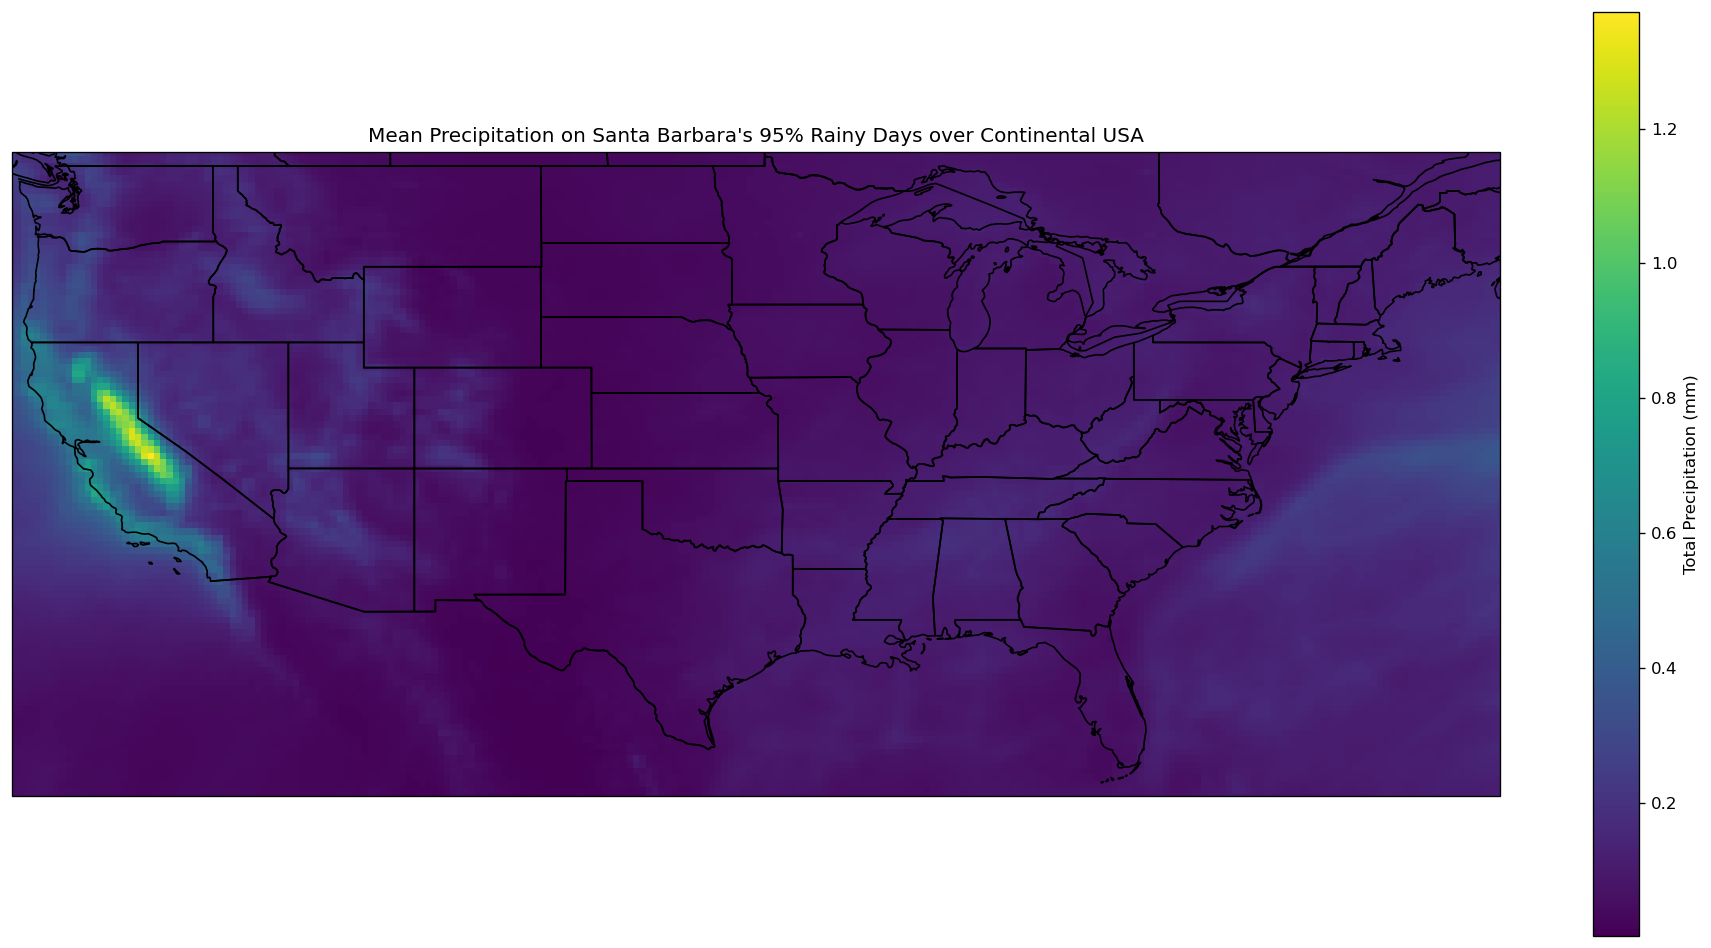

In [67]:
fig = plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())  
ax.set_extent([-125, -66, 24, 46])   
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES) 
cbar = mean_95days['total_precipitation'].plot(ax=ax, transform=ccrs.PlateCarree())
cbar.colorbar.set_label('Total Precipitation (mm)')
ax.set_title("Mean Precipitation on Santa Barbara's 95% Rainy Days over Continental USA")
plt.show()

In [59]:
anom = mean_95days - ds_us_19812010_mean_mm
anom

<xarray.Dataset> Size: 101kB
Dimensions:              (latitude: 105, longitude: 237)
Coordinates:
  * latitude             (latitude) float32 420B 50.0 49.75 49.5 ... 24.25 24.0
  * longitude            (longitude) float32 948B 235.0 235.2 ... 293.8 294.0
    quantile             float64 8B 0.95
Data variables:
    total_precipitation  (latitude, longitude) float32 100kB -0.05667 ... 0.0...

And here is question 3 part 2: A map of the anomaly of precipitation from the 1981-2010 mean, plotted on a Cartopy map centered at your city with a 40 x 40 degree lat-lon range.

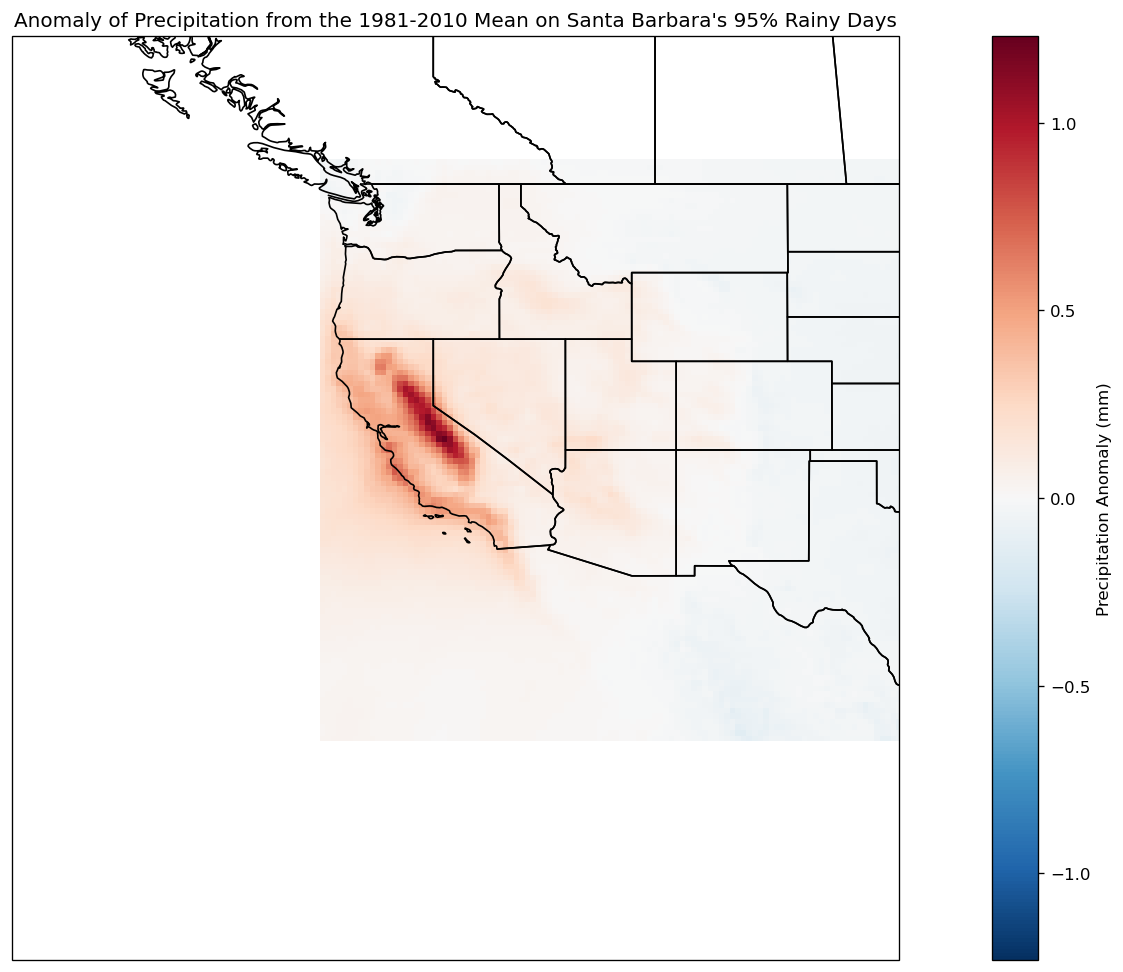

In [66]:
fig = plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())  
ax.set_extent([-139, -99, 14, 54])   
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES) 
cbar = anom['total_precipitation'].plot(ax=ax, transform=ccrs.PlateCarree())
cbar.colorbar.set_label('Precipitation Anomaly (mm)')
ax.set_title("Anomaly of Precipitation from the 1981-2010 Mean on Santa Barbara's 95% Rainy Days")
plt.show()